In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import phik
from phik.report import plot_correlation_matrix

In [2]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
         'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [3]:
df = pd.read_csv('cleaned_train_data.csv', dtype=dtypes)

In [4]:
from sklearn.preprocessing import LabelEncoder
def dummyEncode(df):
        columnsToEncode = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Error encoding '+feature)
        return df

df = dummyEncode(df)

In [5]:
y = df['HasDetections']
X = df.drop(columns = ['HasDetections', 'MachineIdentifier'])

X.replace([np.inf, -np.inf], np.finfo(np.float32).min, inplace=True) # replacing infinity values if any in a dataset to minimum float32 
                                                                    #value because applied log transformation on one feature

In [6]:
features = np.array(list(X))
to_drop = []
for x in features: #check over columns, find any that take only one value
    size = X.groupby([x]).size()
    if (len(size.unique()) == 1):
        to_drop.append(x) #append selected columns to be dropping
to_drop  

['AVProductsEnabled', 'Census_IsWIMBootEnabled']

In [7]:
X = X.drop(to_drop, axis=1)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

min_max_scaler = MinMaxScaler().fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [9]:
results = []
best_result = 0


for i in range(60,110):
        model = tf.keras.models.Sequential([

                    tf.keras.layers.Flatten(input_shape=(74,)), #input, value set by feature selection 
                    tf.keras.layers.Dense(i, activation='relu'), #Hidden layer
                    tf.keras.layers.Dropout(0.2), #dropou
                    tf.keras.layers.Dense(2, activation='softmax') #Layer changes depending on amount of target variables
                    ])

        model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

        epoch = 50
        batch = 1000

        model.fit(X_train,
                    y_train,
                    epochs=epoch,
                    batch_size = batch)
        
        
        X_prob = model.predict(X_test, verbose=0)
        X_classes = model.predict_classes(X_test, verbose=0)

        accuracy = accuracy_score(y_test, X_classes)
        results.append(i)
        results.append(accuracy)
        if accuracy > best_result:
            best_result = accuracy
            layer = i
        
        
        
        

Epoch 1/50
3278/3278 [==============================] - 3s 905us/step - loss: 0.6493 - accuracy: 0.6100
Epoch 2/50
3278/3278 [==============================] - 3s 912us/step - loss: 0.6400 - accuracy: 0.6218
Epoch 3/50
3278/3278 [==============================] - 3s 899us/step - loss: 0.6382 - accuracy: 0.6243
Epoch 4/50
3278/3278 [==============================] - 3s 922us/step - loss: 0.6371 - accuracy: 0.6261
Epoch 5/50
3278/3278 [==============================] - 3s 892us/step - loss: 0.6366 - accuracy: 0.6269
Epoch 6/50
3278/3278 [==============================] - 3s 896us/step - loss: 0.6361 - accuracy: 0.6276
Epoch 7/50
3278/3278 [==============================] - 3s 888us/step - loss: 0.6356 - accuracy: 0.6285
Epoch 8/50
3278/3278 [==============================] - 3s 890us/step - loss: 0.6354 - accuracy: 0.6288
Epoch 9/50
3278/3278 [==============================] - 3s 921us/step - loss: 0.6352 - accuracy: 0.6295
Epoch 10/50
3278/3278 [==============================] - 3s 896u

Epoch 24/50
3278/3278 [==============================] - 3s 943us/step - loss: 0.6335 - accuracy: 0.6318
Epoch 25/50
3278/3278 [==============================] - 3s 922us/step - loss: 0.6333 - accuracy: 0.6318
Epoch 26/50
3278/3278 [==============================] - 3s 929us/step - loss: 0.6334 - accuracy: 0.6317
Epoch 27/50
3278/3278 [==============================] - 3s 941us/step - loss: 0.6333 - accuracy: 0.6321
Epoch 28/50
3278/3278 [==============================] - 3s 954us/step - loss: 0.6332 - accuracy: 0.6322
Epoch 29/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6332 - accuracy: 0.6323
Epoch 30/50
3278/3278 [==============================] - 3s 966us/step - loss: 0.6331 - accuracy: 0.6323
Epoch 31/50
3278/3278 [==============================] - 3s 928us/step - loss: 0.6331 - accuracy: 0.6323
Epoch 32/50
3278/3278 [==============================] - 3s 937us/step - loss: 0.6331 - accuracy: 0.6325
Epoch 33/50
3278/3278 [==============================] - 

3278/3278 [==============================] - 3s 948us/step - loss: 0.6398 - accuracy: 0.6221
Epoch 3/50
3278/3278 [==============================] - 3s 937us/step - loss: 0.6381 - accuracy: 0.6242
Epoch 4/50
3278/3278 [==============================] - 3s 953us/step - loss: 0.6371 - accuracy: 0.6258
Epoch 5/50
3278/3278 [==============================] - 3s 946us/step - loss: 0.6364 - accuracy: 0.6270
Epoch 6/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6358 - accuracy: 0.6280
Epoch 7/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6355 - accuracy: 0.6287
Epoch 8/50
3278/3278 [==============================] - 3s 975us/step - loss: 0.6351 - accuracy: 0.6291
Epoch 9/50
3278/3278 [==============================] - 3s 946us/step - loss: 0.6348 - accuracy: 0.6297
Epoch 10/50
3278/3278 [==============================] - 3s 953us/step - loss: 0.6345 - accuracy: 0.6303
Epoch 11/50
3278/3278 [==============================] - 3s 978us/step - loss:

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6315 - accuracy: 0.6343
Epoch 31/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6314 - accuracy: 0.6345
Epoch 32/50
3278/3278 [==============================] - 3s 988us/step - loss: 0.6313 - accuracy: 0.6345
Epoch 33/50
3278/3278 [==============================] - 3s 996us/step - loss: 0.6312 - accuracy: 0.6347
Epoch 34/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6313 - accuracy: 0.6345
Epoch 35/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6312 - accuracy: 0.6346
Epoch 36/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6310 - accuracy: 0.6347
Epoch 37/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6310 - accuracy: 0.6349
Epoch 38/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6310 - accuracy: 0.6350
Epoch 39/50
3278/3278 [==============================] - 3s 989us/step - loss: 0.

3278/3278 [==============================] - 3s 1ms/step - loss: 0.6346 - accuracy: 0.6300
Epoch 10/50
3278/3278 [==============================] - 3s 963us/step - loss: 0.6343 - accuracy: 0.6306
Epoch 11/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6341 - accuracy: 0.6307
Epoch 12/50
3278/3278 [==============================] - 3s 986us/step - loss: 0.6339 - accuracy: 0.6312
Epoch 13/50
3278/3278 [==============================] - 3s 963us/step - loss: 0.6337 - accuracy: 0.6315
Epoch 14/50
3278/3278 [==============================] - 3s 980us/step - loss: 0.6336 - accuracy: 0.6318
Epoch 15/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6334 - accuracy: 0.6317
Epoch 16/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6333 - accuracy: 0.6320
Epoch 17/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6331 - accuracy: 0.6320
Epoch 18/50
3278/3278 [==============================] - 3s 1ms/step - loss: 

3278/3278 [==============================] - 3s 939us/step - loss: 0.6312 - accuracy: 0.6347
Epoch 38/50
3278/3278 [==============================] - 3s 995us/step - loss: 0.6312 - accuracy: 0.6345
Epoch 39/50
3278/3278 [==============================] - 3s 977us/step - loss: 0.6312 - accuracy: 0.6348
Epoch 40/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6312 - accuracy: 0.6349
Epoch 41/50
3278/3278 [==============================] - 3s 998us/step - loss: 0.6310 - accuracy: 0.6349
Epoch 42/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6310 - accuracy: 0.6349
Epoch 43/50
3278/3278 [==============================] - 3s 993us/step - loss: 0.6310 - accuracy: 0.6349
Epoch 44/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6310 - accuracy: 0.6348
Epoch 45/50
3278/3278 [==============================] - 3s 995us/step - loss: 0.6309 - accuracy: 0.6352
Epoch 46/50
3278/3278 [==============================] - 3s 959us/step - 

3278/3278 [==============================] - 3s 985us/step - loss: 0.6332 - accuracy: 0.6323
Epoch 17/50
3278/3278 [==============================] - 3s 954us/step - loss: 0.6330 - accuracy: 0.6324
Epoch 18/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6329 - accuracy: 0.6323
Epoch 19/50
3278/3278 [==============================] - 3s 990us/step - loss: 0.6329 - accuracy: 0.6323
Epoch 20/50
3278/3278 [==============================] - 3s 1000us/step - loss: 0.6328 - accuracy: 0.6326
Epoch 21/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6327 - accuracy: 0.6328
Epoch 22/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6327 - accuracy: 0.6328
Epoch 23/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6326 - accuracy: 0.6329
Epoch 24/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6326 - accuracy: 0.6329
Epoch 25/50
3278/3278 [==============================] - 3s 1ms/step - loss:

3278/3278 [==============================] - 3s 983us/step - loss: 0.6307 - accuracy: 0.6353
Epoch 45/50
3278/3278 [==============================] - 3s 968us/step - loss: 0.6307 - accuracy: 0.6352
Epoch 46/50
3278/3278 [==============================] - 3s 958us/step - loss: 0.6307 - accuracy: 0.6352
Epoch 47/50
3278/3278 [==============================] - 3s 995us/step - loss: 0.6306 - accuracy: 0.6355
Epoch 48/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6307 - accuracy: 0.6352
Epoch 49/50
3278/3278 [==============================] - 3s 964us/step - loss: 0.6306 - accuracy: 0.6355
Epoch 50/50
3278/3278 [==============================] - 3s 981us/step - loss: 0.6305 - accuracy: 0.6355
Epoch 1/50
3278/3278 [==============================] - 3s 937us/step - loss: 0.6464 - accuracy: 0.6130
Epoch 2/50
3278/3278 [==============================] - 3s 952us/step - loss: 0.6393 - accuracy: 0.6227
Epoch 3/50
3278/3278 [==============================] - 3s 943us/step -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6320 - accuracy: 0.6335
Epoch 23/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6318 - accuracy: 0.6339
Epoch 24/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6318 - accuracy: 0.6336
Epoch 25/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6316 - accuracy: 0.6340
Epoch 26/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6315 - accuracy: 0.6341
Epoch 27/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6315 - accuracy: 0.6342
Epoch 28/50
3278/3278 [==============================] - 3s 986us/step - loss: 0.6313 - accuracy: 0.6344
Epoch 29/50
3278/3278 [==============================] - 3s 976us/step - loss: 0.6314 - accuracy: 0.6343
Epoch 30/50
3278/3278 [==============================] - 3s 998us/step - loss: 0.6313 - accuracy: 0.6346
Epoch 31/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6463 - accuracy: 0.6134
Epoch 2/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6392 - accuracy: 0.6227
Epoch 3/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6373 - accuracy: 0.6256
Epoch 4/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6362 - accuracy: 0.6276
Epoch 5/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6355 - accuracy: 0.6284
Epoch 6/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6351 - accuracy: 0.6292
Epoch 7/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6347 - accuracy: 0.6299
Epoch 8/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6342 - accuracy: 0.6305
Epoch 9/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6340 - accuracy: 0.6306
Epoch 10/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6337 - accurac

3278/3278 [==============================] - 3s 1ms/step - loss: 0.6312 - accuracy: 0.6346
Epoch 31/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6312 - accuracy: 0.6346
Epoch 32/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6311 - accuracy: 0.6348
Epoch 33/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6310 - accuracy: 0.6349
Epoch 34/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6309 - accuracy: 0.6348
Epoch 35/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6310 - accuracy: 0.6350
Epoch 36/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6308 - accuracy: 0.6348
Epoch 37/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6308 - accuracy: 0.6351
Epoch 38/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6308 - accuracy: 0.6353
Epoch 39/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6308 -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6336 - accuracy: 0.6309
Epoch 10/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6334 - accuracy: 0.6314
Epoch 11/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6331 - accuracy: 0.6319
Epoch 12/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6329 - accuracy: 0.6326
Epoch 13/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6327 - accuracy: 0.6326
Epoch 14/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6326 - accuracy: 0.6329
Epoch 15/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6324 - accuracy: 0.6329
Epoch 16/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6323 - accuracy: 0.6331
Epoch 17/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6322 - accuracy: 0.6331
Epoch 18/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6321 -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6312 - accuracy: 0.6343
Epoch 39/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6311 - accuracy: 0.6347
Epoch 40/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6312 - accuracy: 0.6344
Epoch 41/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6311 - accuracy: 0.6345
Epoch 42/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6310 - accuracy: 0.6347
Epoch 43/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6310 - accuracy: 0.6350
Epoch 44/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6310 - accuracy: 0.6348
Epoch 45/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6310 - accuracy: 0.6347
Epoch 46/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6310 - accuracy: 0.6348
Epoch 47/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6309 -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6320 - accuracy: 0.6336
Epoch 18/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6318 - accuracy: 0.6337
Epoch 19/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6316 - accuracy: 0.6340
Epoch 20/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6316 - accuracy: 0.6339
Epoch 21/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6314 - accuracy: 0.6342
Epoch 22/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6313 - accuracy: 0.6343
Epoch 23/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6313 - accuracy: 0.6344
Epoch 24/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6313 - accuracy: 0.6343
Epoch 25/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6312 - accuracy: 0.6345
Epoch 26/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6312 -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6309 - accuracy: 0.6349
Epoch 47/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6308 - accuracy: 0.6348
Epoch 48/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6308 - accuracy: 0.6352
Epoch 49/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6307 - accuracy: 0.6351
Epoch 50/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6308 - accuracy: 0.6352
Epoch 1/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6459 - accuracy: 0.6137
Epoch 2/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6389 - accuracy: 0.6233
Epoch 3/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6368 - accuracy: 0.6263
Epoch 4/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6357 - accuracy: 0.6279
Epoch 5/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6353 - accu

3278/3278 [==============================] - 3s 1ms/step - loss: 0.6314 - accuracy: 0.6347
Epoch 26/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6312 - accuracy: 0.6348
Epoch 27/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6311 - accuracy: 0.6350
Epoch 28/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6310 - accuracy: 0.6348
Epoch 29/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6310 - accuracy: 0.6348
Epoch 30/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6309 - accuracy: 0.6350
Epoch 31/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6308 - accuracy: 0.6352
Epoch 32/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6307 - accuracy: 0.6354
Epoch 33/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6307 - accuracy: 0.6353
Epoch 34/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6306 -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6359 - accuracy: 0.6275
Epoch 5/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6352 - accuracy: 0.6289
Epoch 6/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6345 - accuracy: 0.6297
Epoch 7/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6342 - accuracy: 0.6304
Epoch 8/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6338 - accuracy: 0.6308
Epoch 9/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6336 - accuracy: 0.6313
Epoch 10/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6333 - accuracy: 0.6316
Epoch 11/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6331 - accuracy: 0.6317
Epoch 12/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6327 - accuracy: 0.6326
Epoch 13/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6326 - accu

3278/3278 [==============================] - 3s 1ms/step - loss: 0.6308 - accuracy: 0.6349
Epoch 34/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6307 - accuracy: 0.6351
Epoch 35/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6307 - accuracy: 0.6351
Epoch 36/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6307 - accuracy: 0.6348
Epoch 37/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6306 - accuracy: 0.6353
Epoch 38/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6305 - accuracy: 0.6353
Epoch 39/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6305 - accuracy: 0.6352
Epoch 40/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6305 - accuracy: 0.6352
Epoch 41/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6304 - accuracy: 0.6355
Epoch 42/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6303 -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6324 - accuracy: 0.6328
Epoch 13/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6322 - accuracy: 0.6333
Epoch 14/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6321 - accuracy: 0.6335
Epoch 15/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6318 - accuracy: 0.6339
Epoch 16/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6317 - accuracy: 0.6339
Epoch 17/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6315 - accuracy: 0.6340
Epoch 18/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6315 - accuracy: 0.6343
Epoch 19/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6314 - accuracy: 0.6343
Epoch 20/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6312 - accuracy: 0.6347
Epoch 21/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6311 -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6308 - accuracy: 0.6348
Epoch 42/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6307 - accuracy: 0.6347
Epoch 43/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6308 - accuracy: 0.6349
Epoch 44/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6307 - accuracy: 0.6351
Epoch 45/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6307 - accuracy: 0.6351
Epoch 46/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6306 - accuracy: 0.6352
Epoch 47/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6306 - accuracy: 0.6350
Epoch 48/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6305 - accuracy: 0.6353
Epoch 49/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6304 - accuracy: 0.6353
Epoch 50/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6304 -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6310 - accuracy: 0.6346
Epoch 21/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6309 - accuracy: 0.6348
Epoch 22/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6308 - accuracy: 0.6348
Epoch 23/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6307 - accuracy: 0.6348
Epoch 24/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6306 - accuracy: 0.6352
Epoch 25/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6305 - accuracy: 0.6351
Epoch 26/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6304 - accuracy: 0.6353
Epoch 27/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6304 - accuracy: 0.6352
Epoch 28/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6303 - accuracy: 0.6354
Epoch 29/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6303 -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6297 - accuracy: 0.6365
Epoch 50/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6297 - accuracy: 0.6363
Epoch 1/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6449 - accuracy: 0.6150
Epoch 2/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6383 - accuracy: 0.6240
Epoch 3/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6366 - accuracy: 0.6266
Epoch 4/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6357 - accuracy: 0.6280
Epoch 5/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6351 - accuracy: 0.6291
Epoch 6/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6346 - accuracy: 0.6296
Epoch 7/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6341 - accuracy: 0.6304
Epoch 8/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6339 - accurac

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6305 - accuracy: 0.6353
Epoch 29/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6305 - accuracy: 0.6354
Epoch 30/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6304 - accuracy: 0.6353
Epoch 31/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6304 - accuracy: 0.6357
Epoch 32/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6302 - accuracy: 0.6354
Epoch 33/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6303 - accuracy: 0.6357
Epoch 34/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6302 - accuracy: 0.6359
Epoch 35/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6302 - accuracy: 0.6359
Epoch 36/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6301 - accuracy: 0.6359
Epoch 37/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6301 -

3278/3278 [==============================] - 3s 1ms/step - loss: 0.6340 - accuracy: 0.6304
Epoch 8/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6336 - accuracy: 0.6308
Epoch 9/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6333 - accuracy: 0.6316
Epoch 10/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6330 - accuracy: 0.6318
Epoch 11/50
3278/3278 [==============================] - 3s 1ms/step - loss: 0.6327 - accuracy: 0.6320
Epoch 12/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6326 - accuracy: 0.6326
Epoch 13/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6322 - accuracy: 0.6329
Epoch 14/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6320 - accuracy: 0.6334
Epoch 15/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6318 - accuracy: 0.6336
Epoch 16/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6316 - a

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6305 - accuracy: 0.6351
Epoch 37/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6304 - accuracy: 0.6353
Epoch 38/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6304 - accuracy: 0.6353
Epoch 39/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6303 - accuracy: 0.6353
Epoch 40/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6302 - accuracy: 0.6355
Epoch 41/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6302 - accuracy: 0.6358
Epoch 42/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6301 - accuracy: 0.6356
Epoch 43/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6300 - accuracy: 0.6358
Epoch 44/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6301 - accuracy: 0.6360
Epoch 45/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6300 -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6319 - accuracy: 0.6333
Epoch 16/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6317 - accuracy: 0.6335
Epoch 17/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6316 - accuracy: 0.6336
Epoch 18/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6315 - accuracy: 0.6338
Epoch 19/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6314 - accuracy: 0.6341
Epoch 20/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6313 - accuracy: 0.6342
Epoch 21/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6312 - accuracy: 0.6342
Epoch 22/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6311 - accuracy: 0.6344
Epoch 23/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6311 - accuracy: 0.6345
Epoch 24/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6311 -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6296 - accuracy: 0.6366
Epoch 45/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6295 - accuracy: 0.6367
Epoch 46/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6295 - accuracy: 0.6364
Epoch 47/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6295 - accuracy: 0.6366
Epoch 48/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6294 - accuracy: 0.6365
Epoch 49/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6295 - accuracy: 0.6366
Epoch 50/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6293 - accuracy: 0.6366
Epoch 1/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6457 - accuracy: 0.6138
Epoch 2/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6385 - accuracy: 0.6236
Epoch 3/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6366 - ac

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6306 - accuracy: 0.6351
Epoch 24/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6305 - accuracy: 0.6352
Epoch 25/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6305 - accuracy: 0.6351
Epoch 26/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6304 - accuracy: 0.6352
Epoch 27/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6303 - accuracy: 0.6356
Epoch 28/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6302 - accuracy: 0.6354
Epoch 29/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6303 - accuracy: 0.6354
Epoch 30/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6303 - accuracy: 0.6357
Epoch 31/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6301 - accuracy: 0.6358
Epoch 32/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6301 -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6384 - accuracy: 0.6236
Epoch 3/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6364 - accuracy: 0.6269
Epoch 4/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6353 - accuracy: 0.6286
Epoch 5/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6344 - accuracy: 0.6300
Epoch 6/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6339 - accuracy: 0.6308
Epoch 7/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6334 - accuracy: 0.6313
Epoch 8/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6329 - accuracy: 0.6320
Epoch 9/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6326 - accuracy: 0.6325
Epoch 10/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6324 - accuracy: 0.6328
Epoch 11/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6321 - accura

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6299 - accuracy: 0.6360
Epoch 32/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6299 - accuracy: 0.6360
Epoch 33/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6299 - accuracy: 0.6362
Epoch 34/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6297 - accuracy: 0.6361
Epoch 35/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6298 - accuracy: 0.6362
Epoch 36/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6297 - accuracy: 0.6361
Epoch 37/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6296 - accuracy: 0.6362
Epoch 38/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6296 - accuracy: 0.6361
Epoch 39/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6295 - accuracy: 0.6363
Epoch 40/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6295 -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6325 - accuracy: 0.6324
Epoch 11/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6323 - accuracy: 0.6328
Epoch 12/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6320 - accuracy: 0.6330
Epoch 13/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6319 - accuracy: 0.6336
Epoch 14/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6316 - accuracy: 0.6338
Epoch 15/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6314 - accuracy: 0.6340
Epoch 16/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6313 - accuracy: 0.6343
Epoch 17/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6310 - accuracy: 0.6346
Epoch 18/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6308 - accuracy: 0.6346
Epoch 19/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6307 -

3278/3278 [==============================] - 4s 1ms/step - loss: 0.6293 - accuracy: 0.6368
Epoch 40/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6293 - accuracy: 0.6366
Epoch 41/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6293 - accuracy: 0.6368
Epoch 42/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6291 - accuracy: 0.6367
Epoch 43/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6291 - accuracy: 0.6370
Epoch 44/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6291 - accuracy: 0.6368
Epoch 45/50
3278/3278 [==============================] - 5s 1ms/step - loss: 0.6291 - accuracy: 0.6371
Epoch 46/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6290 - accuracy: 0.6371
Epoch 47/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6290 - accuracy: 0.6370
Epoch 48/50
3278/3278 [==============================] - 4s 1ms/step - loss: 0.6289 -

In [10]:
print(results)

[60, 0.6370392516977748, 61, 0.6362619057788408, 62, 0.6378361227889268, 63, 0.6378471056982995, 64, 0.6385182834932974, 65, 0.6384340811881067, 66, 0.6360239427424325, 67, 0.6389026853213416, 68, 0.6385976045054335, 69, 0.6380008664295171, 70, 0.6389832266567413, 71, 0.6372601302084923, 72, 0.6387257384481149, 73, 0.638183914919062, 74, 0.6378275805260814, 75, 0.6385573338377336, 76, 0.6385805199797426, 77, 0.6378715121635722, 78, 0.6374736867796279, 79, 0.63827055787078, 80, 0.638482894118652, 81, 0.6377201920788816, 82, 0.6383986918134614, 83, 0.6386866881036787, 84, 0.6377555814535271, 85, 0.6379923241666717, 86, 0.6390125144150686, 87, 0.6380740858253351, 88, 0.6399802307631292, 89, 0.6380240525715262, 90, 0.6383974714901978, 91, 0.6388453301279509, 92, 0.6388892617654417, 93, 0.6393395610497221, 94, 0.6392626806841132, 95, 0.6392285116327315, 96, 0.6400046372284018, 97, 0.6375700923174549, 98, 0.6373089431390375, 99, 0.6380655435624897, 100, 0.6392016645209316, 101, 0.64027676931

In [11]:
print(best_result, layer)

0.6402767693161918 101


In [12]:


print('Accuracy: %f' % accuracy)

y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report




print(classification_report(y_test, y_pred_test))

Accuracy: 0.640014
              precision    recall  f1-score   support

           0       0.63      0.63      0.63    400536
           1       0.65      0.65      0.65    418919

    accuracy                           0.64    819455
   macro avg       0.64      0.64      0.64    819455
weighted avg       0.64      0.64      0.64    819455



Text(0.5, 1.0, 'Confusion Matrix for Final Results')

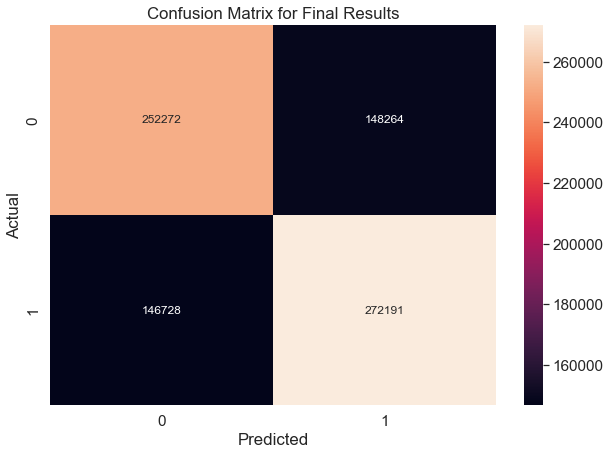

In [13]:
cf_matrix = confusion_matrix(y_test, y_pred_test)


# plot heat map confusion matrix
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
ax = sns.heatmap(cf_matrix, annot=True, annot_kws={"size": 12}, fmt='g')
bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Final Results')